<a href="https://colab.research.google.com/github/dhgrassi/Grupo-de-Estudos-DS/blob/main/Desafio_Kaggle_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
# importa o data set

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras

df = pd.read_csv('train.csv')

In [18]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


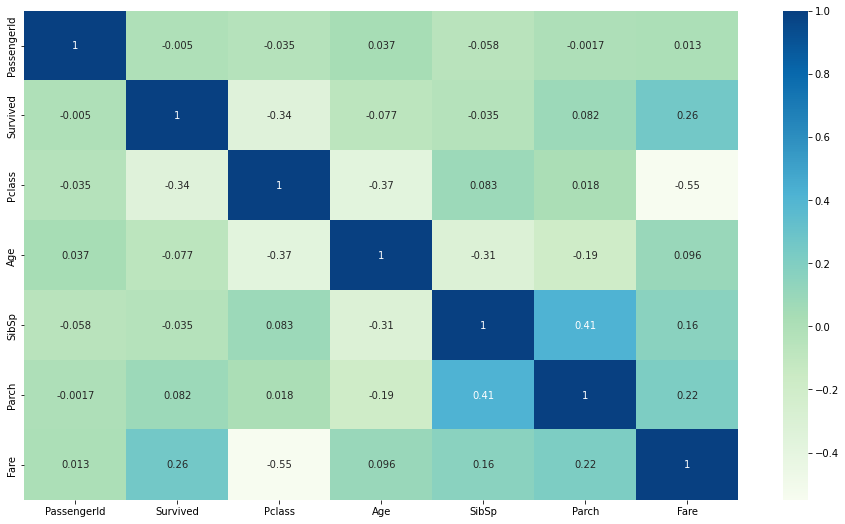

In [24]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),
            annot=True,
            cmap="GnBu")

#Numeric correlation shows that survived or not has stronger correlation with Pclass and Fare

In [26]:
#Transforming sex in numeric variable

sexcode = df['Sex'].astype("category").cat.codes

df.insert(1,"sexcode", sexcode.astype(float))
df

,PassengerId,sexcode,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1.0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,0.0,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,0.0,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,0.0,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,1.0,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,1.0,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,0.0,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0.0,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1.0,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [50]:
#Removing columns with no correlation
df_mod = df.drop(columns=['Name','Sex','Ticket','Cabin','Embarked'])

#Reordening columns
new_cols=["PassengerId","sexcode","Pclass","Age","SibSp","Parch","Fare","Survived"]
df_mod=df_mod.reindex(columns=new_cols)

In [88]:
df_mod = df_mod.dropna()
df_mod

,PassengerId,sexcode,Pclass,Age,SibSp,Parch,Fare,Survived
0,1,1.0,3,22.0,1,0,7.2500,0
1,2,0.0,1,38.0,1,0,71.2833,1
2,3,0.0,3,26.0,0,0,7.9250,1
3,4,0.0,1,35.0,1,0,53.1000,1
4,5,1.0,3,35.0,0,0,8.0500,0
...,...,...,...,...,...,...,...,...
885,886,0.0,3,39.0,0,5,29.1250,0
886,887,1.0,2,27.0,0,0,13.0000,0
887,888,0.0,1,19.0,0,0,30.0000,1
889,890,1.0,1,26.0,0,0,30.0000,1


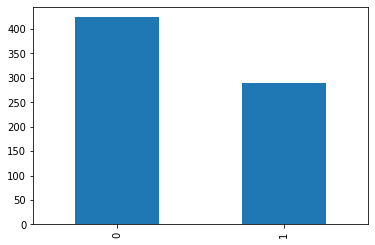

In [89]:
df_mod['Survived'].value_counts().plot(kind = 'bar')

In [53]:
df_mod['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [90]:
#Conver to numpy array in order to input in tensorflow
nparray = df_mod.to_numpy()

In [91]:
features = (nparray[:,0:6]).astype(float)
targets = (nparray[:,7]).astype(int)  ## cria problema binário
print("Features = ", features.shape)
print("Targets = ", targets.shape)

Features =  (714, 6)
Targets =  (714,)


In [92]:
X_train, X_val, y_train, y_val = train_test_split(features, targets, 
                                     test_size=0.25, random_state=0)

In [93]:
print("Exemplos de treinamento:", len(X_train))
print("Exemplos de validacao:", len(X_val))

Exemplos de treinamento: 535
Exemplos de validacao: 179


In [94]:
X_train

array([[536.,   0.,   2.,   7.,   0.,   2.],
       [130.,   1.,   3.,  45.,   0.,   0.],
       [492.,   1.,   3.,  21.,   0.,   0.],
       ...,
       [790.,   1.,   1.,  46.,   0.,   0.],
       [705.,   1.,   3.,  26.,   1.,   0.],
       [857.,   0.,   1.,  45.,   1.,   1.]])

In [95]:
y_train

array([1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,

In [96]:
#Shallow MLP with 1 layer
model1 = keras.Sequential(
 [
   keras.layers.Dense(8, activation="relu", input_shape=(X_train.shape[-1],)),
   keras.layers.Dense(1, activation="sigmoid"),
 ]
)

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8)                 56        
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________


In [97]:
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

# compilamos o modelo utilizando:
#- um otimizador SGD
#- a função de perda entropia cruzada
#- as métricas acima
model1.compile(
    optimizer=keras.optimizers.SGD(), loss="binary_crossentropy", metrics=metrics
)

In [98]:
batch_size = 10
epochs = 30

In [99]:
len(X_train)/batch_size

53.5

In [100]:
history1 = model1.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,  ## mostra as iteracoes
    validation_data=(X_val, y_val),
)

Epoch 1/30
54/54 [==============================] - 2s 14ms/step - loss: 9.2318 - fn: 206.0000 - fp: 18.0000 - tn: 303.0000 - tp: 8.0000 - precision: 0.3077 - recall: 0.0374 - val_loss: 0.6992 - val_fn: 75.0000 - val_fp: 0.0000e+00 - val_tn: 103.0000 - val_tp: 1.0000 - val_precision: 1.0000 - val_recall: 0.0132
Epoch 2/30
54/54 [==============================] - 0s 2ms/step - loss: 0.6907 - fn: 213.0000 - fp: 5.0000 - tn: 316.0000 - tp: 1.0000 - precision: 0.1667 - recall: 0.0047 - val_loss: 0.6976 - val_fn: 76.0000 - val_fp: 0.0000e+00 - val_tn: 103.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
54/54 [==============================] - 0s 2ms/step - loss: 0.6871 - fn: 212.0000 - fp: 3.0000 - tn: 318.0000 - tp: 2.0000 - precision: 0.4000 - recall: 0.0093 - val_loss: 0.6979 - val_fn: 76.0000 - val_fp: 0.0000e+00 - val_tn: 103.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
54/54 [=======================

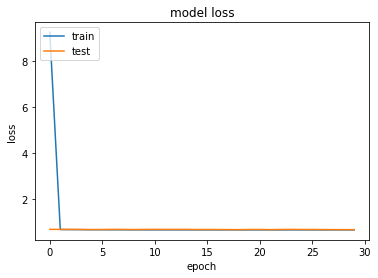

In [101]:
plt.plot(history1.history["loss"])
plt.plot(history1.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [102]:
# Computando as métricas para a validacao
score = model1.evaluate(X_val, y_val, verbose=0)

In [103]:
print("Perda (entropia cruzada): ", score[0])
print("Falsos negativos: ", score[1])
print("Falsos positivos: ", score[2])
print("Verdadeiros negativos: ", score[3])
print("Verdadeiros positivos: ", score[4])
print("Precisao: ", score[5])
print("Revocacao: ", score[6])

Perda (entropia cruzada):  0.6852923631668091
Falsos negativos:  75.0
Falsos positivos:  0.0
Verdadeiros negativos:  103.0
Verdadeiros positivos:  1.0
Precisao:  1.0
Revocacao:  0.01315789483487606
